# Daisy World
## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

# Function to compute the evolution of daisies

The for loop is written within a function, this makes it easy to 're-use the same code' with different parameter settings.  

In [2]:
def DW_simulation(L, WD_area=0.01, BD_area=0.01, growth_rate_temp=0.003265, deathrate=0.2,
                  opt_temp_W=295.65, opt_temp_B=295.65, WD_albedo=0.75, BD_albedo=0.25,
                  barren_albedo=0.5, solar_constant=1000, hor_ins=20, Stefan_Boltzmann=5.67e-08,
                  dt=1.):
               
    # Create lists to store different equilibrium values for WD_area, BD_area and temperature.
    WD_area_list     = []
    BD_area_list     = []
    temperature_list = []
    
    Convergence = False
    n = 0
    while Convergence == False:
        n += 1
        # =====================================================================
        # Solve equations for single L
        # =====================================================================

        # 1 find planetary albedo
        fertile_area = 1-(WD_area + BD_area)
        DW_albedo = (barren_albedo * fertile_area) + (WD_albedo * WD_area) + (BD_albedo * BD_area)

        # 2 find planetary temperature
        DW_temperature = ((solar_constant * L * (1-DW_albedo)) / (Stefan_Boltzmann))**0.25

        # 3 find local temperature of daisies
        # converted to C since the equationg only works with celsius:
        WD_localtemp = (hor_ins*(DW_albedo-WD_albedo) + (DW_temperature)) 
        BD_localtemp = (hor_ins*(DW_albedo-BD_albedo) + (DW_temperature)) 

        # 4 find birthrate for daisy
        #prevent negative birthrate with standard python function max(a,b) 
        dWD_birth = max(0,1-growth_rate_temp*(opt_temp_W - WD_localtemp)**2) * dt
        dBD_birth = max(0,1-growth_rate_temp*(opt_temp_B - BD_localtemp)**2) * dt

        # 5 calulate change in daisy areas due to birth and death
        dWD_area = WD_area * (fertile_area * dWD_birth - deathrate)
        dBD_area = BD_area * (fertile_area * dBD_birth - deathrate)

        # 6 update area's
        #using forward Euler method to approximate differential equation for incease in area over time:
        WD_area += dWD_area * dt
        BD_area += dBD_area * dt
        # ensure that daisys area is >= 0.01, since too lower values will mean
        # no seeds are available on the planet for growing 
        WD_area = max(0.01, WD_area)
        BD_area = max(0.01, BD_area)

        # 7 calculate new albedo
        fertile_area = 1-(WD_area + BD_area)
        DW_albedo = (barren_albedo * fertile_area) + (WD_albedo * WD_area) + (BD_albedo * BD_area)

        # 8 calulate new temperature 
        DW_temp_next = ((solar_constant * L * (1-DW_albedo)) / (Stefan_Boltzmann))**0.25

        # 9 check for convergence of Daisy World temperature 
        Convergence = abs(DW_temperature - DW_temp_next)<1E-6

        # 10 temperature without daisies
        no_daisy_temp = ((solar_constant * L * (1-0.5)) / (Stefan_Boltzmann))**0.25

        if n > 2000:
            Convergence = True
            print('reached max convergence iterations')
        WD_area_list.append(WD_area)
        BD_area_list.append(BD_area)
        temperature_list.append(DW_temp_next)
        
    return temperature_list, WD_area_list, BD_area_list, no_daisy_temp

In [27]:
def daisy_world(luminosity_range, WD_area=0.01, BD_area=0.01, opt_temp_W=295.65, 
                opt_temp_B=295.65, WD_albedo=0.75, BD_albedo=0.25, ):
    # intitalizing lists to store intermediate/output
    eq_temperature = []
    eq_area_WD = []
    eq_area_BD = []
    temp_log_no_daisy = []

    for L in luminosity_range:  
        # =====================================================================
        # Solve equations for single L
        # =====================================================================
        temperature_list, WD_area_list, BD_area_list, no_daisy_temp = DW_simulation(L, 
                                                                                    WD_area=WD_area, 
                                                                                    BD_area=BD_area,
                                                                                    WD_albedo=WD_albedo,
                                                                                    BD_albedo=BD_albedo,
                                                                                    opt_temp_B=opt_temp_B,
                                                                                    opt_temp_W=opt_temp_W)
        # =============================================================================
        # save the equilibrium variables for each L
        # =============================================================================
        DW_temp_eq = temperature_list[-1]
        WD_area = WD_area_list[-1]
        BD_area = BD_area_list[-1]
        eq_temperature.append(DW_temp_eq)
        eq_area_WD.append(WD_area)
        eq_area_BD.append(BD_area)
        temp_log_no_daisy.append(no_daisy_temp)
        
    return eq_temperature, eq_area_WD, eq_area_BD, temp_log_no_daisy

# Plotting functions 

## Temperature of Daisy World as function of time:

In [28]:
def DW_vs_time(temperature_list, WD_area_list, BD_area_list):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[1].plot(temperature_list, label='Temperature')
    ax[1].set_xlabel('timesteps')
    ax[1].set_ylabel('Temperature (K)')
    ax[1].set_title("Evolution of temperature (K)")
    ax[1].legend()
    ax[0].plot(WD_area_list, label='White daisies')
    ax[0].plot(BD_area_list, label='Black daisies')
    ax[0].set_xlabel('timesteps')
    ax[0].set_ylabel('Temperature (K)')
    ax[0].set_title("Evolution of black and white daisies")
    ax[0].legend()
    plt.show()

## Temperature of Daisy World planet as function of luminosity

In [29]:
def DW_vs_lum(luminosity_range, eq_temperature, temp_log_no_daisy, eq_area_WD, eq_area_BD):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[1].plot(luminosity_range, eq_temperature, label='Eq. Temp with daisies')
    ax[1].plot(luminosity_range, temp_log_no_daisy, label='Temperature no daisies')
    ax[1].set_xlabel('Luminosity')
    ax[1].set_ylabel('Temperature (K)')
    ax[1].set_title("Equilibrium temperature (K) versus Luminosity")
    ax[1].legend()
    ax[0].plot(luminosity_range, eq_area_WD, label='Eq. white daisies')
    ax[0].plot(luminosity_range, eq_area_BD, label='Eq. black daisies')
    ax[0].set_xlabel('Luminosity')
    ax[0].set_ylabel('Fraction of coverage')
    ax[0].set_title("Equilibrium coverage of the daisies versus Luminosity")
    ax[0].legend()
    plt.show()

# Results (default)

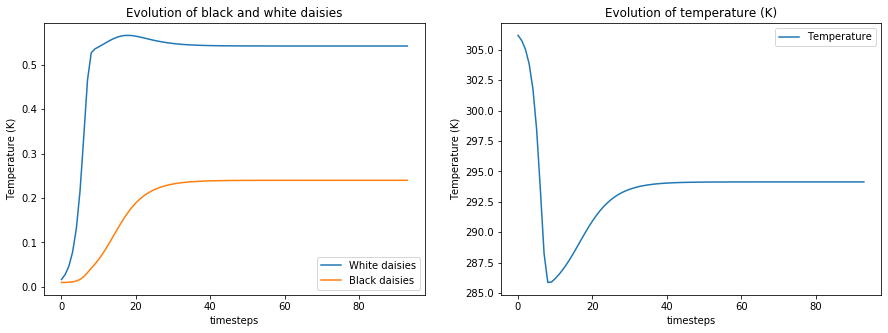

In [30]:
temperature_list, WD_area_list, BD_area_list, no_daisy_temp = DW_simulation(L = 1)
DW_vs_time(temperature_list, WD_area_list, BD_area_list)

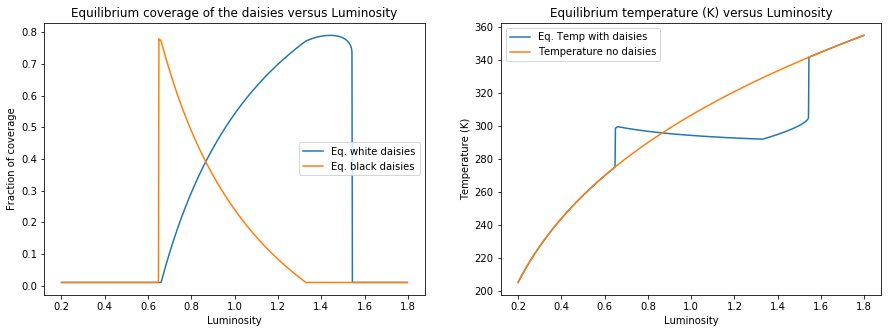

In [36]:
luminosity_range = np.arange(0.2, 1.8, 0.002)

# call function
out = daisy_world(luminosity_range)
eq_temperature, eq_area_WD, eq_area_BD, temp_log_no_daisy = out

# plotting
DW_vs_lum(luminosity_range, eq_temperature, temp_log_no_daisy, eq_area_WD, eq_area_BD)

## Changing albedo

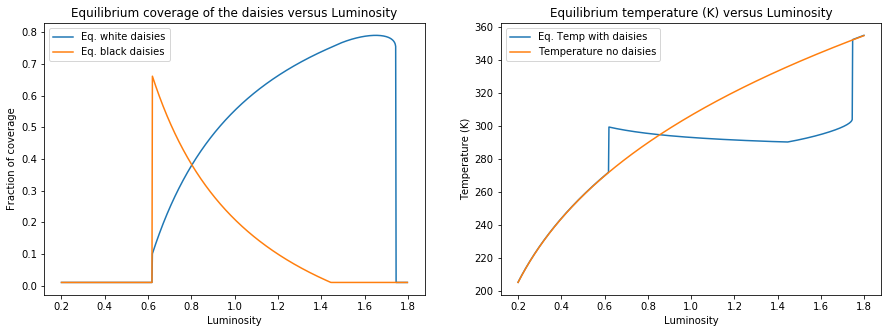

In [32]:
kwrgs = {'WD_albedo': 0.8,
         'BD_albedo': 0.1}

luminosity_range = np.arange(0.2, 1.8, 0.002)

# call function
out = daisy_world(luminosity_range, **kwrgs)
eq_temperature, eq_area_WD, eq_area_BD, temp_log_no_daisy = out

# plotting
DW_vs_lum(luminosity_range, eq_temperature, temp_log_no_daisy, eq_area_WD, eq_area_BD)

## Changing optimal temperature black daisies

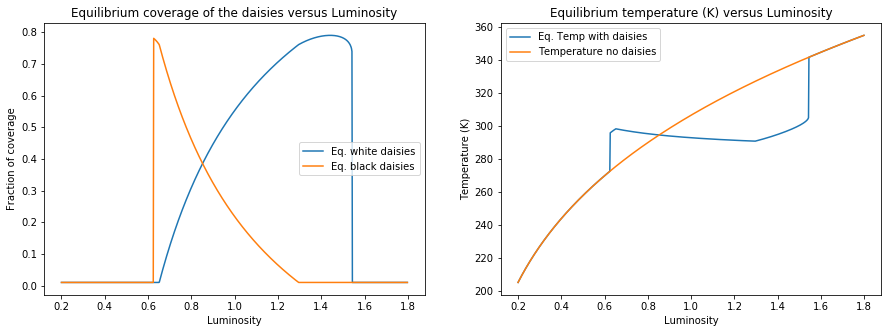

In [34]:
opt_temp_B = 20
opt_temp_B += 273.15
kwrgs = {'opt_temp_B' : opt_temp_B}

# call function
out = daisy_world(luminosity_range, **kwrgs)
eq_temperature, eq_area_WD, eq_area_BD, temp_log_no_daisy = out

# plotting
DW_vs_lum(luminosity_range, eq_temperature, temp_log_no_daisy, eq_area_WD, eq_area_BD)

## Showing hysteresis by inverting the starting luminosity 

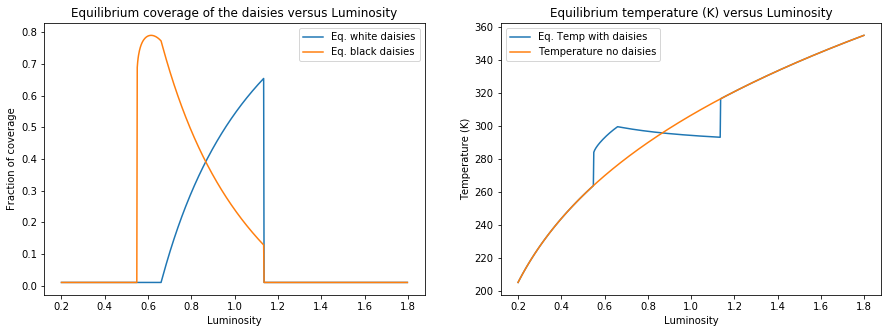

In [40]:
luminosity_range = np.arange(0.2, 1.8, 0.002)
luminosity_range = luminosity_range[::-1] # this is how you invert a list/nparray

# call function
out = daisy_world(luminosity_range) 
eq_temperature, eq_area_WD, eq_area_BD, temp_log_no_daisy = out

# plotting
DW_vs_lum(luminosity_range, eq_temperature, temp_log_no_daisy, eq_area_WD, eq_area_BD)